# 시계열 예측

- 시계열 데이터 분석의 목적
 - 1) 미래 시계열 값의 예측 (forecasting)
 - 2) 시계열 패턴을 분류 (정상, 고장, 위험 등)- 단변수 시계열 예측
- 베이스라인 모델
- Prophet 모델

- 시계열 예측: 과거 샘플 값을 보고 미래 값을 예측

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

- 선형 회귀 (linear regression) 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## 날씨 데이터

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(df.shape)
df[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- train_test_split을 사용하려면 순서를 유지해야 한다 (shuiffling=False)
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

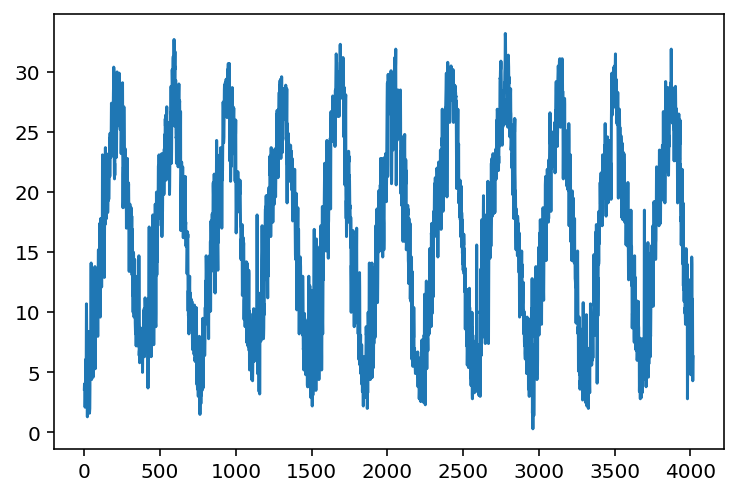

In [6]:
y = df["기온"].values
plt.plot(y)

In [7]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누는 예
ratio = 0.75
cut = np.int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

<ipython-input-7-1c963954ae87>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut = np.int(len(y)*ratio)


(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 예측하는 것을 walk forward 예측이라고 한다

## 시계열 데이터를 테이블 구조로 만들기
- 시계열 예측에서 머신러닝 모델을 쉽게 적용하기 위해서 비정형인(크기가 일정치 않은) 시계열 데이터를 정형 데이터인 테이블 구조로 만드들어야 한다
- 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - data는 입력 시계열 데이터 (위 그림에서 len(data)=13임)
 - n_steps는 한 샘플의 크기 (위 그림에서 5)

In [8]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

In [9]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
data = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(data, 4)

pd.DataFrame(list(zip(x_train, y_train)), columns=['X','y'])

,X,y
0,"[1, 2, 3, 4]",5
1,"[2, 3, 4, 5]",6
2,"[3, 4, 5, 6]",7
3,"[4, 5, 6, 7]",8
4,"[5, 6, 7, 8]",9
5,"[6, 7, 8, 9]",10
6,"[7, 8, 9, 10]",11
7,"[8, 9, 10, 11]",12
8,"[9, 10, 11, 12]",13


## 선형 회귀 예측 모델 

In [10]:
model = LinearRegression()

n_steps = 10
x_train, y_train = split_seq(train_data, n_steps)
x_test, y_test = split_seq(test_data, n_steps)
model.fit(x_train, y_train) 
model.score(x_test, y_test).round(4) 

0.936

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [16]:
# 선형 회귀 예측의 여러가지 성능 평가 지표

def show_regression_result(y_test, y_pred, N=150):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("max error=", max(error).round(4))
    #  잔차  (residue) 산포도
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b*--', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

MAE= 1.4979
max error= 8.6136
R2= 0.936


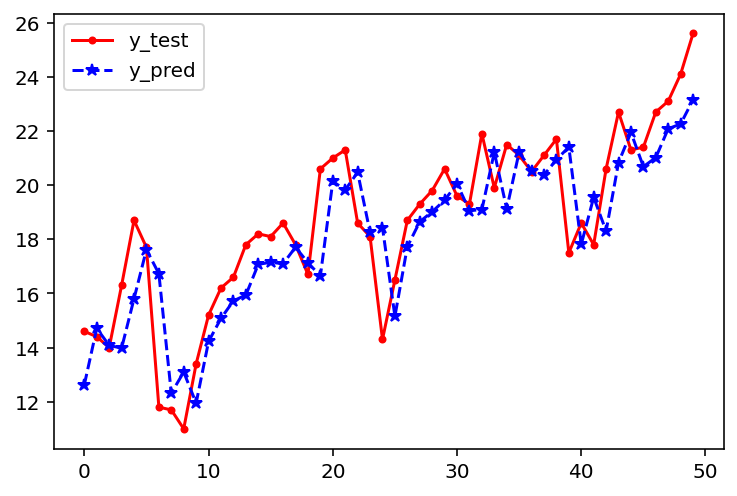

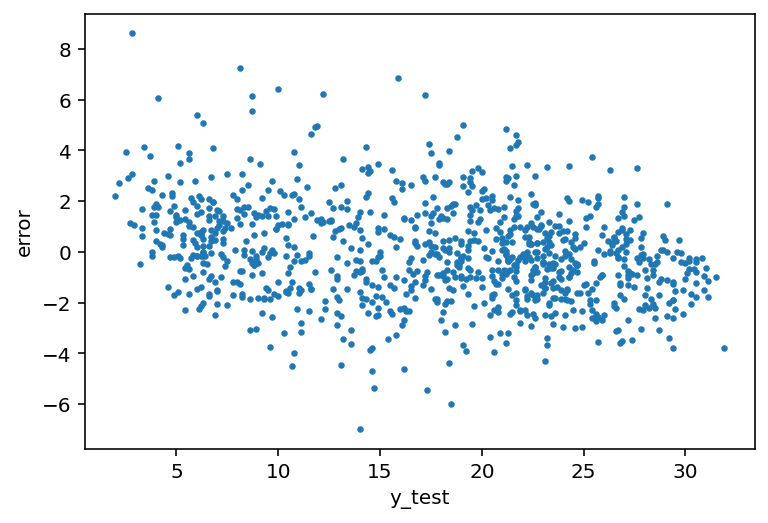

In [14]:
show_regression_result(y_test, y_pred,50)

# 베이스라인 모델
- 간단히 만들 수 있는 모델, 나이브 모델이라고도 한다
- 새로운 모델은 이것보다는 좋아야 하는 기준
- 종류
 - persistent 모델: 직전의 샘플 값으로 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다, ema)
 - 직전 값들이 아니라 주기적인 일정 간격을 두고 샘플을 취하여 평균을 얻기도 한다

## persistent 모델

In [15]:
# 현재 값으로 다음 값을 예측하는 경우
x_test, y_test = split_seq(test_data, 1) 

In [16]:
x_test[:5], y_test[:5]

(array([[15.2],
        [13.8],
        [15.3],
        [11.4],
        [ 9. ]]),
 array([13.8, 15.3, 11.4,  9. , 11.4]))

MAE= 1.5846
max error= 10.4
R2= 0.9266


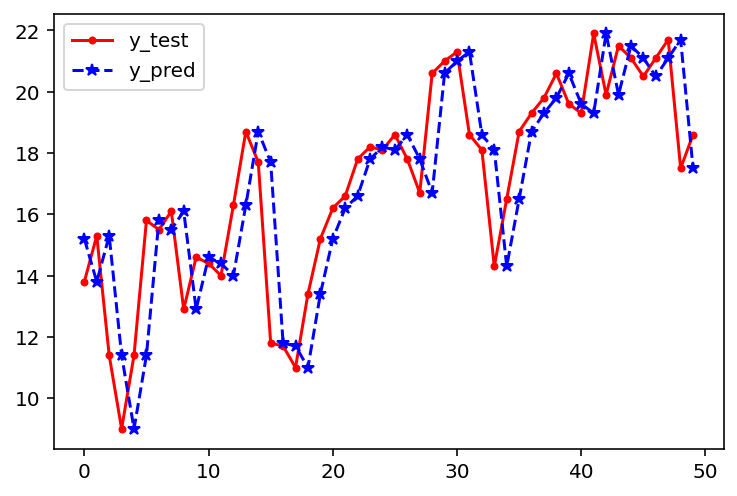

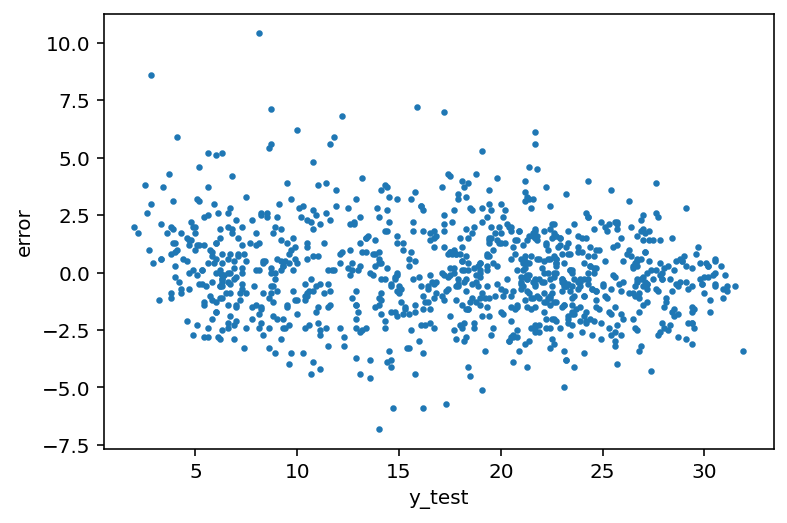

In [17]:
# 현재 값을 다음 예측값으로 사용
y_pred = x_test.ravel()
show_regression_result(y_test, y_pred, 50)

## 과거의 평균치로 예측하는 경우

In [18]:
# 입력 데이터의 평균치를 리턴하는 함수
def average_model(seq):
    return np.array(seq).mean(axis=1)

In [19]:
# 평균할 갯수 최적의 찾기
result = {}
for i in range(1,20): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [20]:
result

{1: 0.9266,
 2: 0.9166,
 3: 0.9113,
 4: 0.9074,
 5: 0.9037,
 6: 0.901,
 7: 0.8991,
 8: 0.8982,
 9: 0.8971,
 10: 0.896,
 11: 0.8948,
 12: 0.8932,
 13: 0.8913,
 14: 0.8897,
 15: 0.888,
 16: 0.8861,
 17: 0.8841,
 18: 0.8812,
 19: 0.8778}

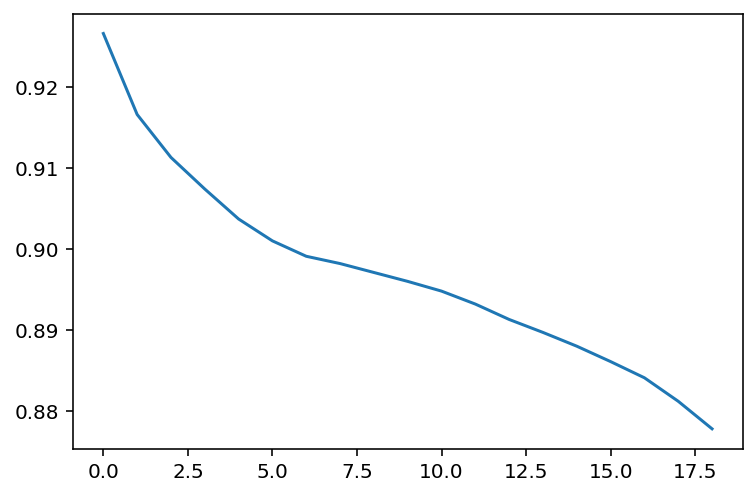

In [21]:
plt.plot(result.values())

In [22]:
min(result, key=result.get)

19

- 날씨 예측의 경우, 직전 값으로 예측하는 persistent 모델의 성능이 가장 좋다

# Prophet 

- fbprophet을 설치해야 함,  conda install -c conda-forge fbprophet
- PC에서 설치가 안되면 colab에서 실행한다
- 날짜와 값을 포함하는 데이터프레임을 입력으로 사용한다
- 반드시 ['ds', 'y'] 이름의 컬럼명을 사용해야 한다

In [23]:
# !mamba install -c conda-forge fbprophet  -y
# !conda install -c conda-forge fbprophet
# 아나콘다가 설치되지 않았으면 파이썬과 쥬피터노트북만 따로 설치후에 
#   (파이썬  버전이 2.6 이하여야 한다)

In [17]:
from fbprophet import Prophet

In [18]:
df[:3]

,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


In [19]:
df = df.drop(["품질", "균질"], axis=1)
df.columns = ['ds', 'y'] # 컬러명이 ds, y로 고정되어 있다
df[:3]

,ds,y
0,2006/1/1,3.6
1,2006/1/2,4.0
2,2006/1/3,3.7


In [20]:
#datetime 포맷으로 바꾼다
df.ds = df.ds.apply(pd.to_datetime)
df.ds[:3]

0   2006-01-01
1   2006-01-02
2   2006-01-03
Name: ds, dtype: datetime64[ns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4018 non-null   datetime64[ns]
 1   y       4018 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.9 KB


In [22]:
df[:10]

,ds,y
0,2006-01-01,3.6
1,2006-01-02,4.0
2,2006-01-03,3.7
3,2006-01-04,4.0
4,2006-01-05,3.6
5,2006-01-06,2.1
6,2006-01-07,2.8
7,2006-01-08,4.2
8,2006-01-09,3.7
9,2006-01-10,4.3


### 훈련, 검증 데이터 나누기

In [23]:
train = df[:2000]
test = df[2000:]
train.shape, test.shape

((2000, 2), (2018, 2))

In [24]:
model = Prophet()
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
# 예측할 기간의 날짜 정보가 필요하다
future_test = test.drop('y',axis=1)
future_test

,ds
2000,2011-06-24
2001,2011-06-25
2002,2011-06-26
2003,2011-06-27
2004,2011-06-28
...,...
4013,2016-12-27
4014,2016-12-28
4015,2016-12-29
4016,2016-12-30


In [28]:
forecast = model.predict(future_test)
forecast[:3]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-06-24,16.480133,21.006742,27.430809,16.480133,16.480133,7.694612,7.694612,7.694612,0.085629,0.085629,0.085629,7.608983,7.608983,7.608983,0.0,0.0,0.0,24.174746
1,2011-06-25,16.479592,21.141522,27.472216,16.479592,16.479592,7.920223,7.920223,7.920223,0.147655,0.147655,0.147655,7.772568,7.772568,7.772568,0.0,0.0,0.0,24.399815
2,2011-06-26,16.479051,21.323239,27.490903,16.479051,16.479051,7.862273,7.862273,7.862273,-0.060710,-0.060710,-0.060710,7.922983,7.922983,7.922983,0.0,0.0,0.0,24.341324


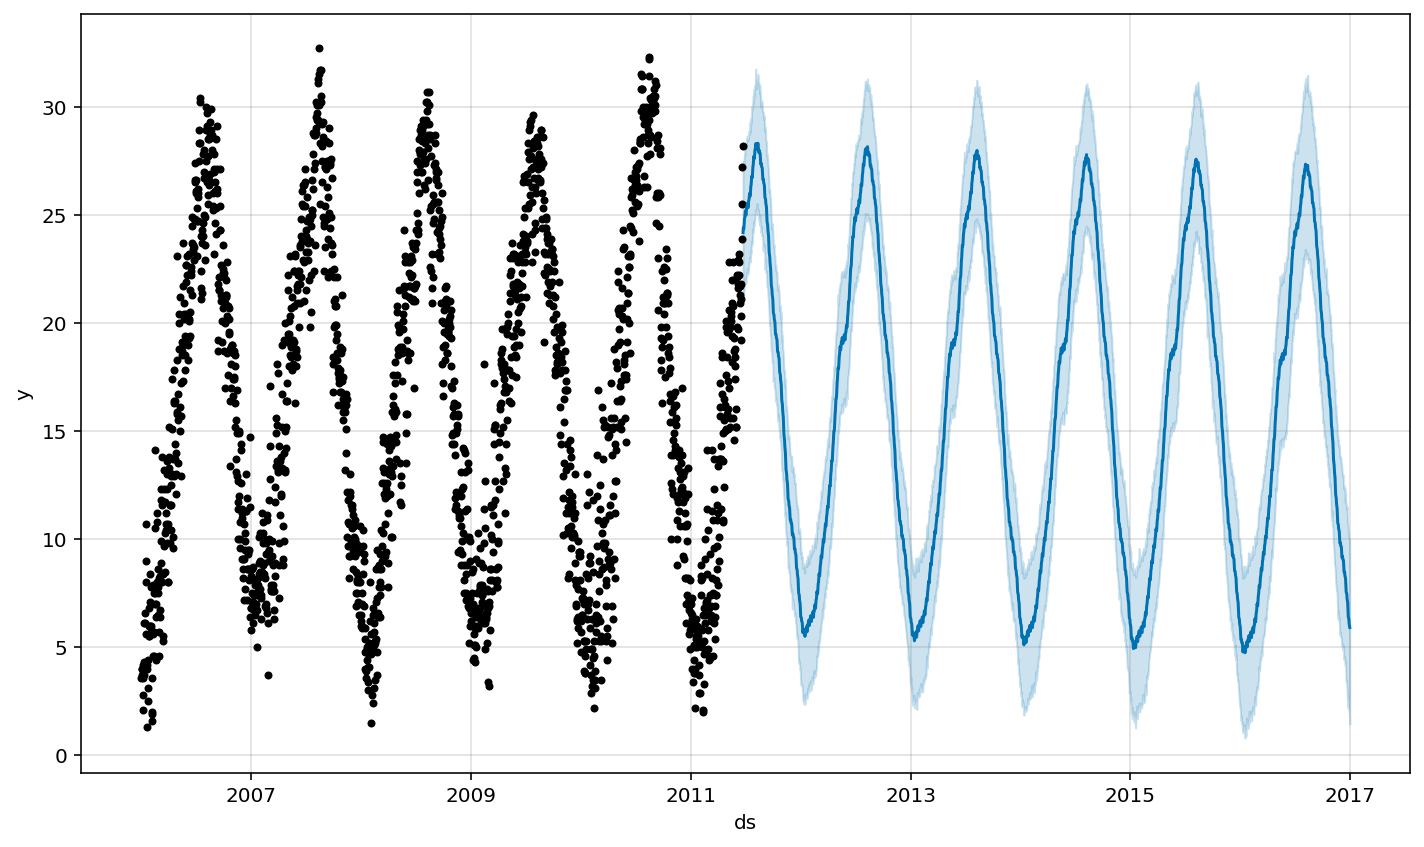

In [29]:
model.plot(forecast)
from datetime import datetime
# plt.xlim([datetime(2015, 7, 1), datetime(2015, 10, 1)])
plt.show()

In [30]:
y_test = test.y
y_test.shape

(2018,)

In [31]:
y_pred = forecast['yhat']
r2_score(y_test, y_pred)

0.897097000057929

In [65]:
# 선형모델 0.93, 나이브모델의 0.926에 비해서 성능이 나쁘다?? 
# prophet 모델은 현재 값까지만 알려주고 모든 미래값을 한번에 예측한 것
# 다른 장점: 결측치가 있어도 잘 동작한다, 특별한 이벤트를 반영할 수 있다